Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
#Imports
%matplotlib inline
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from scipy.stats import randint, uniform
import matplotlib as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

In [4]:
#Perform our train/test/split on the data
train, val  = train_test_split(train, train_size=0.8, test_size=0.2, stratify=train['status_group'], random_state=42)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [5]:
train['status_group'].value_counts()

functional                 25807
non functional             18259
functional needs repair     3454
Name: status_group, dtype: int64

In [6]:
baseline = (25807 / (25807 + 18259 + 3454))

print('Naive baseline: ', baseline)

Naive baseline:  0.5430765993265994


In [7]:
def wrangle_data(X):
  """Function for wrangling all of our data sets in the same manner"""

  #Prevent a SettingWithCopyWarning
  X = X.copy()

  #Replace the near-0 values in latitude with 0's for easier handling
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  #Now we will replace the 0's with null values for easier handling
  cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                     'gps_height', 'population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING'] = X[col].isnull()

  #Drop redundant or non-useful columns
  red_cols = ['quantity_group', 'payment_type', 'recorded_by', 'id']
  X = X.drop(columns=red_cols)

  #Convert date_recorded to a datetime object
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format = True)

  #Extract the date elements and then drop the original date/time column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  #Engineering new features
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  #Return the wrangled dataframe
  return X

In [8]:
# Target
target = 'status_group'

# Dropping target
train_features = train.drop(columns = [target])

# Numeric features
numeric_features = train_features.select_dtypes(include = 'number').columns.tolist()

# Cardinality of non-numeric features
cardinality = train_features.select_dtypes(exclude = 'number').nunique()

# Categorical features with cardinality <= 30
categorical_features = cardinality[cardinality <= 30].index.tolist()

# Combining lists
features= numeric_features + categorical_features

In [9]:
# Train/test/validation split

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [10]:
# Model

model = make_pipeline(
    FunctionTransformer(wrangle_data, validate=False),
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=200, min_samples_leaf=1, random_state=42)
)

#Fit the data to our model

model.fit(X_train, y_train)
print('Training accuracy:', model.score(X_train, y_train))
print('Validation accuracy:', model.score(X_val, y_val))

Training accuracy: 0.9999789562289563
Validation accuracy: 0.8132154882154882


In [12]:
# Model
model = make_pipeline(
    FunctionTransformer(wrangle_data, validate=False),
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=200, min_samples_leaf=1, random_state=42)
)

#Fit data to model
model.fit(X_train, y_train)
print('Training accuracy:', model.score(X_train, y_train))
print('Validation accuracy:', model.score(X_val, y_val))

Training accuracy: 0.9999789562289563
Validation accuracy: 0.8132154882154882


In [13]:
y_pred = model.predict(X_val)
print('Validation Accuracy: ', accuracy_score(y_val, y_pred))

Validation Accuracy:  0.8132154882154882


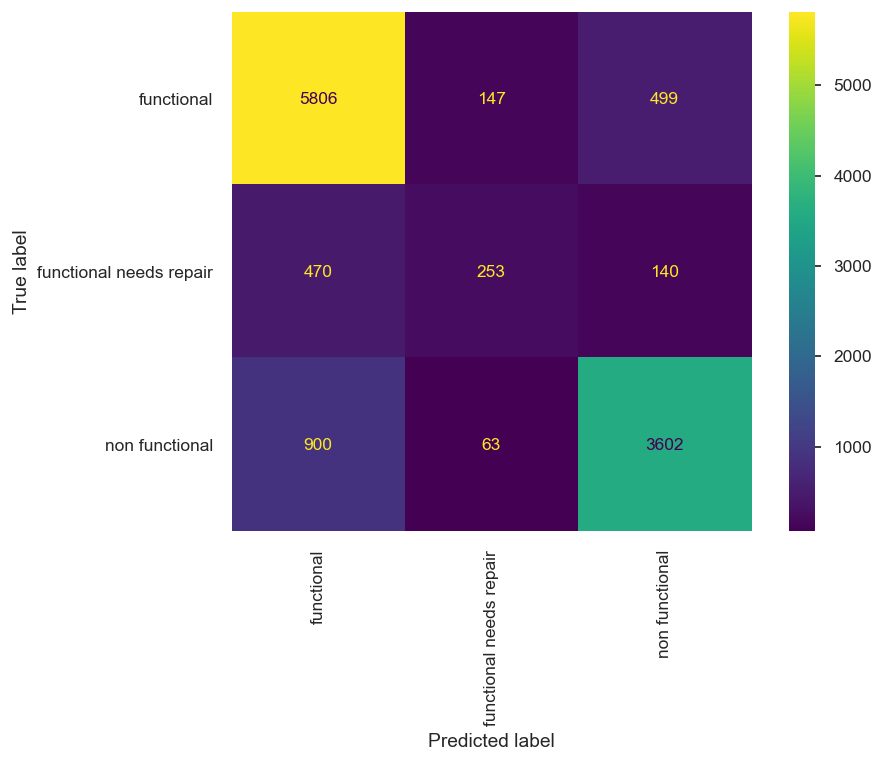

In [15]:
#Confusion matrix on validation data

plt.rcParams['figure.dpi'] = 125

plot_confusion_matrix(model, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [18]:
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

y_pred = model.predict(X_test)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Brad_Brauser_Submission_5.csv', index=False)